In [1]:
import numpy as np
import pandas as pd
from scipy.fft import fft
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import torch.optim as optim
import torch
import torch.nn as nn
import time


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

dim_signal = 256
dataset_samples = 100000
time_symbols = [np.random.randn(1, dim_signal).T for _ in range(dataset_samples)] 


fft_result = np.fft.fft(time_symbols, axis=1)

# Real part of the Fourier transform
real_part = np.real(fft_result)

# Imaginary part of the Fourier transform
imaginary_part = np.imag(fft_result)


In [3]:
real_part = np.reshape(real_part, (dataset_samples, dim_signal))
imaginary_part = np.reshape(imaginary_part, (dataset_samples, dim_signal))


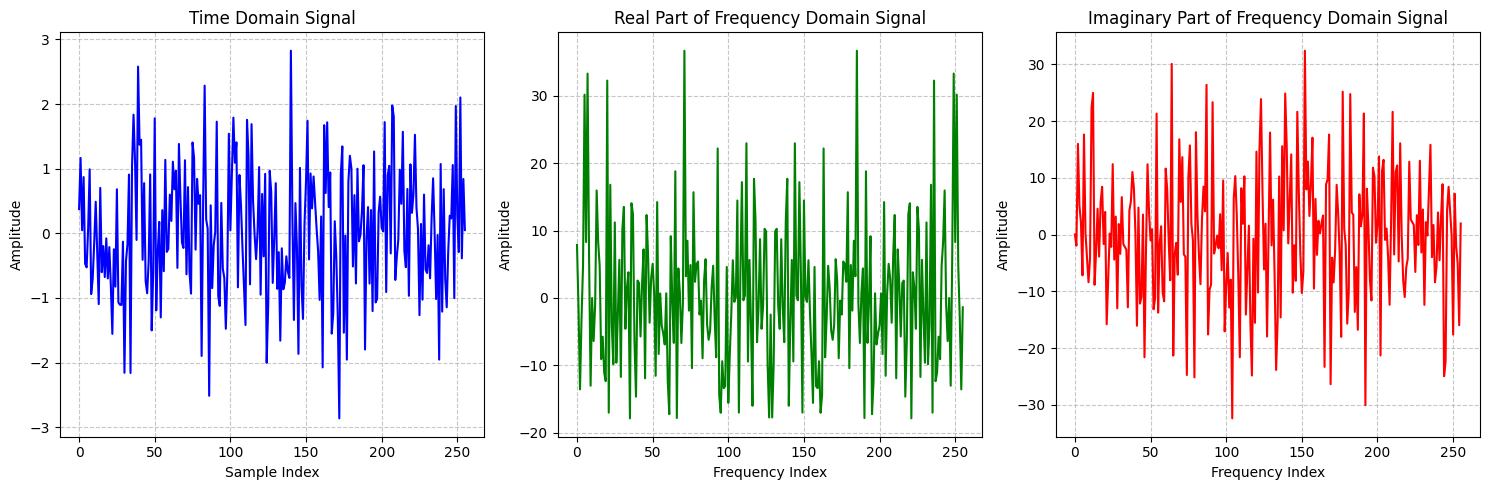

In [4]:
random_index = np.random.randint(0, dataset_samples)

time_sample = time_symbols[random_index]
cos_sample = real_part[random_index]
sin_sample = imaginary_part[random_index]

# Plot time domain signal
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(time_sample, color='blue')
plt.title('Time Domain Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True, linestyle='--', alpha=0.7)

# Plot real part of frequency domain signal
plt.subplot(1, 3, 2)
plt.plot(cos_sample, color='green')
plt.title('Real Part of Frequency Domain Signal')
plt.xlabel('Frequency Index')
plt.ylabel('Amplitude')
plt.grid(True, linestyle='--', alpha=0.7)

# Plot imaginary part of frequency domain signal
plt.subplot(1, 3, 3)
plt.plot(sin_sample, color='red')
plt.title('Imaginary Part of Frequency Domain Signal')
plt.xlabel('Frequency Index')
plt.ylabel('Amplitude')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [5]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available")
else:
    device = torch.device('cpu')
    print("GPU is not available, using CPU.")

# If GPU is available, set up GPU memory growth
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

GPU is available


In [6]:
X = np.array(time_symbols, dtype=np.float32)
y_real = np.array(real_part, dtype=np.float32)
y_imag=np.array(imaginary_part, dtype=np.float32)

In [7]:
X_train, X_val, y_real_train, y_real_val, y_imag_train, y_imag_val = train_test_split(X, y_real, y_imag, test_size=0.2, random_state=42)

In [8]:
X_train_tensor = torch.tensor(X_train)
y_real_train_tensor = torch.tensor(y_real_train)
y_imag_train_tensor = torch.tensor(y_imag_train)

X_val_tensor = torch.tensor(X_val)
y_real_val_tensor = torch.tensor(y_real_val)
y_imag_val_tensor = torch.tensor(y_imag_val)

# Move tensors to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = X_train_tensor.to(device)
y_real_train_tensor = y_real_train_tensor.to(device)
y_imag_train_tensor = y_imag_train_tensor.to(device)

X_val_tensor = X_val_tensor.to(device)
y_real_val_tensor = y_real_val_tensor.to(device)
y_imag_val_tensor = y_imag_val_tensor.to(device)

In [9]:

class FFTModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FFTModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3_real = nn.Linear(512, output_dim)
        self.fc4_imag = nn.Linear(512, output_dim)
    
    def forward(self, x):
        x = x.view(-1, x.size(1))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        real_part = self.fc3_real(x)
        imag_part = self.fc4_imag(x)
        return real_part, imag_part

In [10]:
model = FFTModel(input_dim=dim_signal, output_dim=dim_signal)
model.to(device)

FFTModel(
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3_real): Linear(in_features=512, out_features=256, bias=True)
  (fc4_imag): Linear(in_features=512, out_features=256, bias=True)
)

In [11]:
X_train_tensor = torch.tensor(X_train)
y_real_train_tensor = torch.tensor(y_real_train)
y_imag_train_tensor = torch.tensor(y_imag_train)

X_val_tensor = torch.tensor(X_val)
y_real_val_tensor = torch.tensor(y_real_val)
y_imag_val_tensor = torch.tensor(y_imag_val)

# Move tensors to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = X_train_tensor.to(device)
y_real_train_tensor = y_real_train_tensor.to(device)
y_imag_train_tensor = y_imag_train_tensor.to(device)

X_val_tensor = X_val_tensor.to(device)
y_real_val_tensor = y_real_val_tensor.to(device)
y_imag_val_tensor = y_imag_val_tensor.to(device)



In [12]:
def calculate_loss(model, criterion, X_val_tensor, y_real_val_tensor, y_imag_val_tensor, batch_size):
    val_loss = 0.0
    
    # Set model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        for i in range(0, X_val_tensor.size(0), batch_size):
            # Get mini-batch inputs and targets
            inputs = X_val_tensor[i:i+batch_size]
            targets_real = y_real_val_tensor[i:i+batch_size]
            targets_imag = y_imag_val_tensor[i:i+batch_size]
            
            # Forward pass
            outputs_real, outputs_imag = model(inputs.float())
            
            loss = criterion(outputs_real, targets_real.float()) + criterion(outputs_imag, targets_imag.float())
            
            val_loss += loss.item() * inputs.size(0)
    
    # Average validation loss
    val_loss = val_loss / len(X_val_tensor)
    return val_loss

# Function to train the model and return losses
def train_model(model, criterion, optimizer, num_epochs, X_train_tensor, y_real_train_tensor, y_imag_train_tensor, X_val_tensor, y_real_val_tensor, y_imag_val_tensor, batch_size):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Set model to train mode
        model.train()
        train_loss = 0.0

        # Shuffle the data
        indices = torch.randperm(X_train_tensor.size(0))
        X_train_tensor = X_train_tensor[indices]
        y_real_train_tensor = y_real_train_tensor[indices]
        y_imag_train_tensor = y_imag_train_tensor[indices]

        # Mini-batch training
        for i in range(0, X_train_tensor.size(0), batch_size):
            # Get mini-batch inputs and targets
            inputs = X_train_tensor[i:i+batch_size]
            targets_real = y_real_train_tensor[i:i+batch_size]
            targets_imag = y_imag_train_tensor[i:i+batch_size]

            # Forward pass
            outputs_real, outputs_imag = model(inputs.float())

            loss = criterion(outputs_real, targets_real.float()) + criterion(outputs_imag, targets_imag.float())

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        # Average epoch training loss
        train_loss = train_loss / len(X_train_tensor)
        train_losses.append(train_loss)

        # Calculate validation loss
        val_loss = calculate_loss(model, criterion, X_val_tensor, y_real_val_tensor, y_imag_val_tensor, batch_size)
        val_losses.append(val_loss)

        # Print epoch loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    print('Training finished!')
    return train_losses, val_losses



In [34]:
least_loss = float('inf')
print(least_loss)
best_parameters={}
batch_size=1024
criterion = nn.MSELoss()
from torch.optim import Adam,RMSprop,Adagrad
for epoch in [50,75,100]:
        for lr in [.01,.001,.0001,]:
            for opti in [Adam,Adagrad,RMSprop]:
                model=FFTModel(256, 256)
                model.to(device=device)
                optimizer = opti(model.parameters(), lr=lr)
                train_losses, val_losses = train_model(model, criterion, optimizer, epoch, X_train_tensor, y_real_train_tensor, y_imag_train_tensor, X_val_tensor, y_real_val_tensor, y_imag_val_tensor, batch_size)
                print(np.mean(np.array(val_losses)))
                if np.mean(np.array(val_losses)) < least_losses:
                    print("hi")
                    np.mean(np.array(val_losses))
                    least_losses = np.mean(np.array(val_losses))
                    best_parameters = {'epoch': epoch, 'lr': lr,'optimizer': opti}

print("Best Parameters:", best_parameters)

inf
Epoch [1/50], Train Loss: 138.5255, Val Loss: 83.1296
Epoch [2/50], Train Loss: 63.4475, Val Loss: 76.3725
Epoch [3/50], Train Loss: 37.3736, Val Loss: 24.8763
Epoch [4/50], Train Loss: 26.3502, Val Loss: 18.1223
Epoch [5/50], Train Loss: 23.0876, Val Loss: 16.7103
Epoch [6/50], Train Loss: 16.8125, Val Loss: 8.6938
Epoch [7/50], Train Loss: 20.5023, Val Loss: 18.6817
Epoch [8/50], Train Loss: 16.0084, Val Loss: 6.0355
Epoch [9/50], Train Loss: 13.8599, Val Loss: 9.0790
Epoch [10/50], Train Loss: 20.8735, Val Loss: 24.1823
Epoch [11/50], Train Loss: 10.8616, Val Loss: 10.7001
Epoch [12/50], Train Loss: 14.1891, Val Loss: 7.8852
Epoch [13/50], Train Loss: 14.7012, Val Loss: 5.7620
Epoch [14/50], Train Loss: 14.1901, Val Loss: 7.2681
Epoch [15/50], Train Loss: 12.5876, Val Loss: 7.4761
Epoch [16/50], Train Loss: 12.0558, Val Loss: 4.0729
Epoch [17/50], Train Loss: 11.3391, Val Loss: 3.5000
Epoch [18/50], Train Loss: 13.0698, Val Loss: 9.6682
Epoch [19/50], Train Loss: 14.0777, Val Lo

Epoch [1/100], Train Loss: 221.9061, Val Loss: 165.0585
Epoch [2/100], Train Loss: 126.1137, Val Loss: 98.5296
Epoch [3/100], Train Loss: 79.9836, Val Loss: 67.4770
Epoch [4/100], Train Loss: 56.2849, Val Loss: 49.7358
Epoch [5/100], Train Loss: 42.3033, Val Loss: 38.8763
Epoch [6/100], Train Loss: 33.8911, Val Loss: 32.6176
Epoch [7/100], Train Loss: 29.3649, Val Loss: 29.2533
Epoch [8/100], Train Loss: 27.0365, Val Loss: 27.4736
Epoch [9/100], Train Loss: 25.1611, Val Loss: 25.7475
Epoch [10/100], Train Loss: 23.2787, Val Loss: 23.6048
Epoch [11/100], Train Loss: 21.3269, Val Loss: 21.6269
Epoch [12/100], Train Loss: 19.3020, Val Loss: 19.4409
Epoch [13/100], Train Loss: 17.1957, Val Loss: 17.3475
Epoch [14/100], Train Loss: 15.0181, Val Loss: 14.9762
Epoch [15/100], Train Loss: 12.8346, Val Loss: 12.7597
Epoch [16/100], Train Loss: 10.7501, Val Loss: 10.6161
Epoch [17/100], Train Loss: 8.8153, Val Loss: 8.6600
Epoch [18/100], Train Loss: 7.1279, Val Loss: 7.0628
Epoch [19/100], Trai

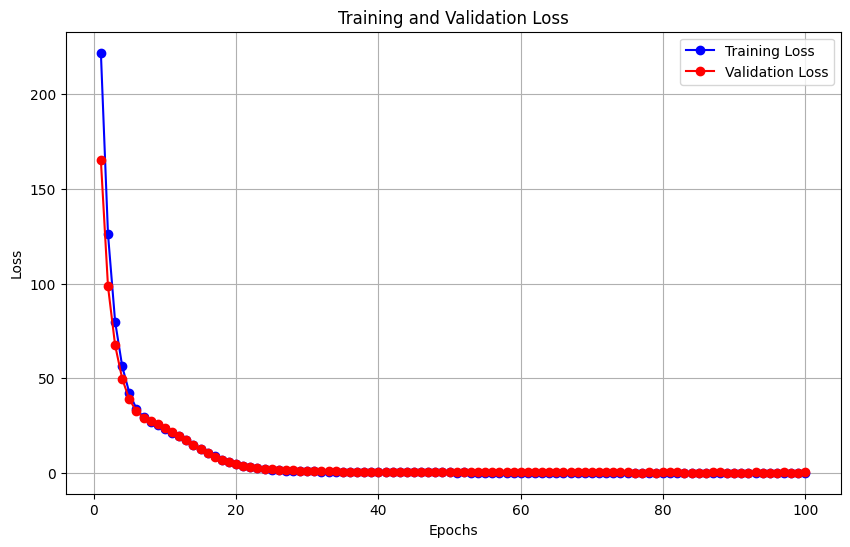

In [35]:

num_epochs = best_parameters['epoch']
lr = best_parameters['lr']
opti = best_parameters['optimizer']

model = FFTModel(256, 256)
model.to(device=device)
optimizer = opti(model.parameters(), lr=lr)

train_losses, val_losses = train_model(model, criterion, optimizer, num_epochs, X_train_tensor, y_real_train_tensor, y_imag_train_tensor, X_val_tensor, y_real_val_tensor, y_imag_val_tensor, batch_size)

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, num_epochs + 1), train_losses, label='Training Loss', linestyle='-', marker='o', color='b')
plt.plot(np.arange(1, num_epochs + 1), val_losses, label='Validation Loss', linestyle='-', marker='o', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid(True)
plt.legend()
plt.show()

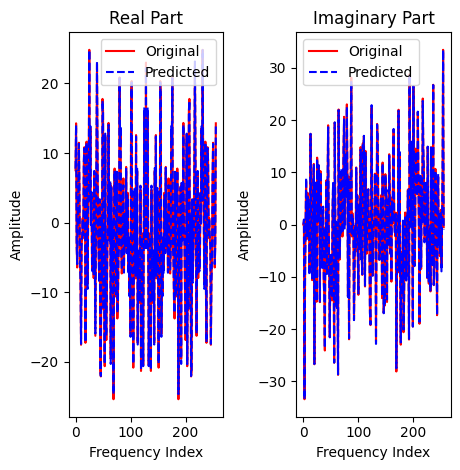

In [36]:
# Generate a single sample
dim_signal = 256
time_symbol = np.random.randn(1, dim_signal).T

# Compute FFT
fft_result = np.fft.fft(time_symbol, axis=0)

# Real part of the Fourier transform
real_part = np.real(fft_result)

# Imaginary part of the Fourier transform
imaginary_part = np.imag(fft_result)

# Convert the sample to PyTorch tensor and move it to the appropriate device
time_symbol_tensor = torch.tensor(time_symbol).unsqueeze(0).float().to(device)

# Get network output
model.eval()
with torch.no_grad():
    output_real, output_imag = model(time_symbol_tensor)
    output_real = output_real.squeeze().cpu().numpy()
    output_imag = output_imag.squeeze().cpu().numpy()

# Plot real part of frequency domain signal
plt.subplot(1, 3, 2)
plt.plot(real_part, color='red', label='Original')
plt.plot(output_real, color='blue', linestyle='--', label='Predicted')
plt.title('Real Part')
plt.xlabel('Frequency Index')
plt.ylabel('Amplitude')
plt.legend()

# Plot imaginary part of frequency domain signal
plt.subplot(1, 3, 3)
plt.plot(imaginary_part, color='red', label='Original')
plt.plot(output_imag, color='blue', linestyle='--', label='Predicted')
plt.title('Imaginary Part')
plt.xlabel('Frequency Index')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import time

# Define different dataset sizes
dataset_sizes = [10,100,1000, 10000, 100000,200000,300000,400000,500000, 1000000]

fft_times = []
model_times = []

for size in dataset_sizes:
    # Generate new random data
    new_data = [np.random.randn(1, dim_signal).T for _ in range(size)]
    new_data_array = np.array(new_data)
    
    # Convert to PyTorch tensor and move to GPU
    inputs = torch.from_numpy(new_data_array).to(device=device, dtype=torch.float32)
    
    # Measure the time taken by FFT
    start_time_fft = time.time()
    fft_result_new = np.fft.fft(new_data_array, axis=1)
    end_time_fft = time.time()
    fft_time = end_time_fft - start_time_fft
    
    # Measure the time taken by the model
    start_time_model = time.time()
    with torch.no_grad():
        model.eval()
        outputs_real, outputs_imag = model(inputs)
    end_time_model = time.time()
    model_time = end_time_model - start_time_model
    
    fft_times.append(fft_time)
    model_times.append(model_time)

# Plot the time difference
plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, fft_times, label='FFT Time', linestyle='-', marker='o', color='b')
plt.plot(dataset_sizes, model_times, label='Model Time', linestyle='-', marker='o', color='r')
plt.xlabel('Dataset Size')
plt.ylabel('Time (s)')
plt.title('Time Comparison between FFT and Model')
plt.grid(True)
plt.legend()
plt.show()